# Cumulative Scaffold Frequency Plots (CSFPs)

#### In this notebook, we will write a few function to mathematically and visually describe the scaffold diversity of molecules in two screening libraries. You can read more about the science behind CSFPs here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3180201/

#### Import libraries

In [16]:
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Tuple

#### Read in Intermed LeadLike Library

In [3]:
df_leadlike = PandasTools.LoadSDF("data/Intermed_3D-Shaped_Leadlike_S.sdf", molColName='Molecule')

In [4]:
df_leadlike = df_leadlike[["ID", "Molecule"]]

In [13]:
print("Molecules in library 1: ", df_leadlike.shape[0])

Molecules in library:  1240


###### Show somes structures

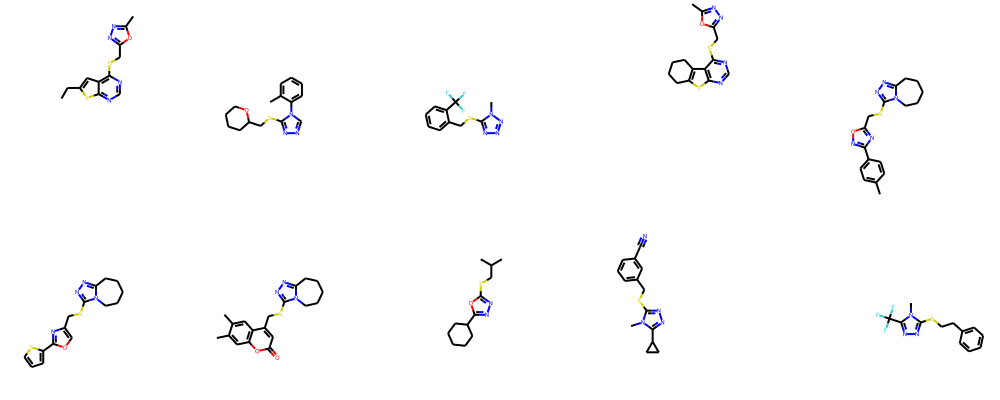

In [7]:
MolsToGridImage([mol for mol in df_leadlike.Molecule[:10]], molsPerRow=5)

#### Do the same for the Intermed Diversity Library

In [8]:
df_10k = PandasTools.LoadSDF("data/Intermed_HTS_diversity_10k.sdf", molColName='Molecule')

In [9]:
df_10k = df_10k[["ID", "Molecule"]]

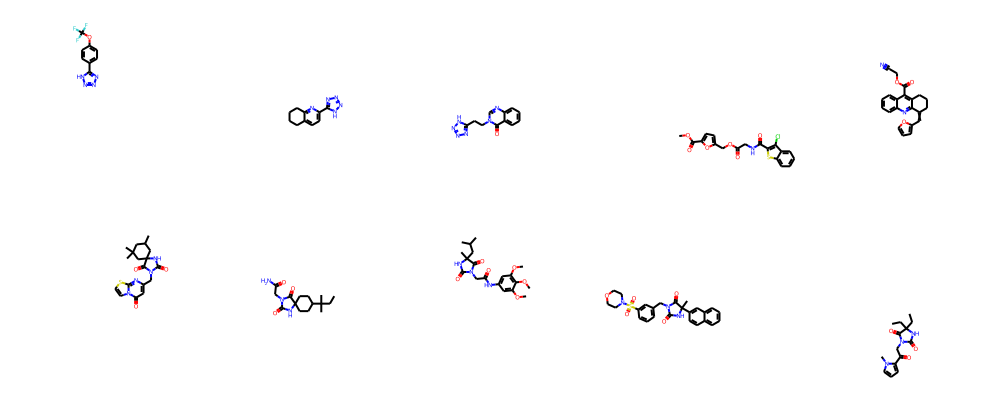

In [10]:
MolsToGridImage([mol for mol in df_10k.Molecule[:10]], molsPerRow=5)

In [14]:
print("Molecules in library 2: ", df_10k.shape[0])

Molecules in library 2:  10240


==========================================

### Next we will define some functions that will calculate the Cumulative Scaffold Frequency and p50. In the csfp function, we will return the p50, which tells us what % of scaffolds cover 50% of all the molecules in the library. This is measure of library diversity - lower p50s indicate that only a few scaffolds cover 50% of all molecules.  We will also return the dataframe with the necessary calculates to make the cumulative scaffold frequency plot.  

### Function for CSFP

In [17]:
def csfp(df: pd.DataFrame, mol_col: str) -> Tuple:
    """
    Calculate cumulative scaffold frequency
    :param df: dataframe with molecules
    :return: tuple with scaffold frequency calculated in a df and the p50
    """
    
    df = df.dropna()

    rdkit.Chem.PandasTools.AddMurckoToFrame(df, molCol=mol_col, MurckoCol='Murcko_SMILES')

    df = df[df.Murcko_SMILES != ""]

    dff = pd.DataFrame(df.groupby('Murcko_SMILES', as_index=False)
                       [df.columns[1]].count()).sort_values(by=df.columns[1], ascending=False).reset_index()

    dff['cum_sum'] = dff.iloc[:, 2].cumsum()

    dff['scaff_freq'] = (dff.cum_sum / dff.cum_sum.max())*100

    dff['cpd_index'] = pd.DataFrame({'X': range(1, dff.shape[0] + 1, 1)})

    dff['cpd_freq'] = (dff.cpd_index / dff.cpd_index.max())*100
    
    p50 = round(dff['cpd_freq'].iloc[(dff['scaff_freq']-50.0).abs().argsort()[:1]].values[0],2)
    
    print('Number of Scaffolds: ', dff.shape[0])
    print("p50:", p50)

    return dff, p50

In [52]:
def csfp_plot(df: pd.DataFrame):
    """
    Cumulative scaffold frequency plot
    :param df: dataframe with the frequencies
    :return: plots
    """
    plt.plot(df.cpd_freq, df.scaff_freq, label="Library")
    plt.plot([0, 100], [0, 100], linestyle='dashed', color="black", label="unique")
    plt.title("Cumulative Scaffold Frequency Plot")
    plt.xticks(np.arange(0, 110, 10))
    plt.yticks(np.arange(0, 110, 10))
    plt.xlabel("Percentage of Scaffolds")
    plt.ylabel("Percentage of Molecules")
    plt.legend()    
    
    return plt.show()

#### Let's see how many scaffolds there are the Leadlike library and get the p50

In [19]:
df_leadlike_csfp, leadlike_p50 = csfp(df_leadlike, "Molecule")

Number of Scaffolds:  1063
p50: 41.67


### This p50 is near 50, which means the library is very diverse in terms of scaffolds. But let's view this visually.  A library that is entirely unique in terms of scaffolds would be a straight line - every molecule is represented by a unique scaffold aka no redundant scaffolds. So CSFPs that look like straight lines are more scaffold diverse.  

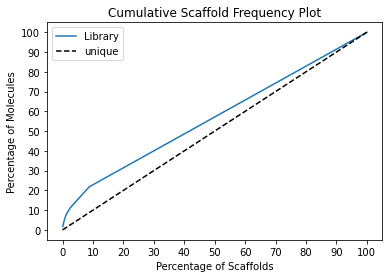

In [55]:
csfp_plot(df_leadlike_csfp)

#### Let's compute the p50 for the Diversity library. 

In [25]:
df_10k_csfp, _ = csfp(df_10k, "Molecule")

Number of Scaffolds:  8266
p50: 38.52


### The p50 of the LeadLike library is higher than Diversity library, which indicates that more of the LeadLike library is covered by unique scaffolds.  The Leadlike Library should be closer the straight line than the Diversity library. Let's plot the two libraries together and see.

##### Let's define a simple function to plot the two cumulative scaffold frequencies

In [26]:
def csfp_plot2(df1, df2):
    """
    Cumulative scaffold frequency plot
    :param df: dataframe with the frequencies
    :return: plots
    """
    plt.plot(df1.cpd_freq, df1.scaff_freq, label="LeadLike")
    plt.plot(df2.cpd_freq, df2.scaff_freq, label="Diversity")
    plt.plot([0, 100], [0, 100], linestyle='dashed', color="black", label="unique")
    plt.title("Cumulative Scaffold Frequency Plot")
    plt.xticks(np.arange(0, 110, 10))
    plt.yticks(np.arange(0, 110, 10))
    plt.xlabel("Percentage of Scaffolds")
    plt.ylabel("Percentage of Molecules")
    plt.legend()

    
    
    return plt.show()

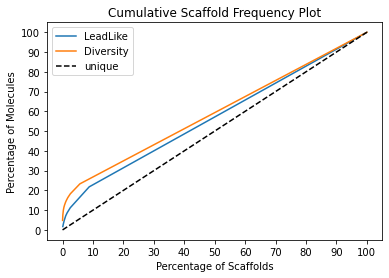

In [27]:
csfp_plot2(df_leadlike_csfp, df_10k_csfp)

### Like we expected, the LeadLike library is closer to the straight line! (But both libraries are scaffold diverse, all things considered)

=====================================

### Homework ;)

##### Find a "focused" library from a vendor. Calculate the p50 and make the CSFP.  Would do you expect the plot to look like? Closer to the straight line or shifted to the left?  Why?

## See you next time. =StuftyJello=